### Predicting Exit Speed, Angle, and Direction for MLB
Prepared by: David L. Parks  
February 03, 2022

#### Introduction

The goal of this project is to predict the EXIT_SPEED, ANGLE, and DIRECTION for each row in the test.csv dataset. We will try four separate methods to complete this task. First, we try the naive approach which uses the mean of each target variable as our "best guess" for each outcome. Next, we try a simulation using the mean and standard deviation of each target variable to select a normally distributed number as our "best guess" for each outcome. Third, we employ single output regressors against the target variables individually and use the best regressor for each output to collectively predict the target variables. Lastly, we employ a multiple output regressor against the target variables collectively. Each method will be scored using Root Mean Squared Error (RMSE). The method that produces the lowest RMSE will be employed against the test.csv dataset.

*NOTE: This notebook uses the Intel Extension for Scikit-learn and enables multicore processing when possible. This configuration potentially decreases model training and inference processing time by 10 - 100 times. If your system does not use Intel processors and/or have multiple cores, you MUST make changes to the cell below for the notebook to run successfully.*

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

# enable the Intel Extension for Scikit-learn
# COMMENT OUT THE NEXT TWO LINES IF YOUR SYSTEM
# DOES NOT USE INTEL PROCESSORS
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# set options
pd.options.display.max_columns = 30
pd.options.display.max_rows = 500
sns.set()

# set the number of cores when multicore
# processing is enabled
# SET n_jobs = 1 IF YOUR SYSTEM DOES NOT
# HAVE MULTIPLE CORES
n_jobs = 6

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# load the data files
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Usually at this point we would inspect the data looking for outliers and NULL values. Since that was completed during the last project, those steps are ignored. However, we are going to generate histogram plots for the target variables to get a sense of how they are distributed.

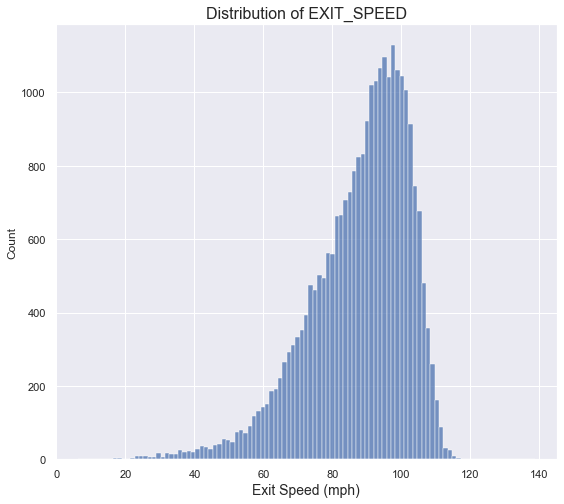

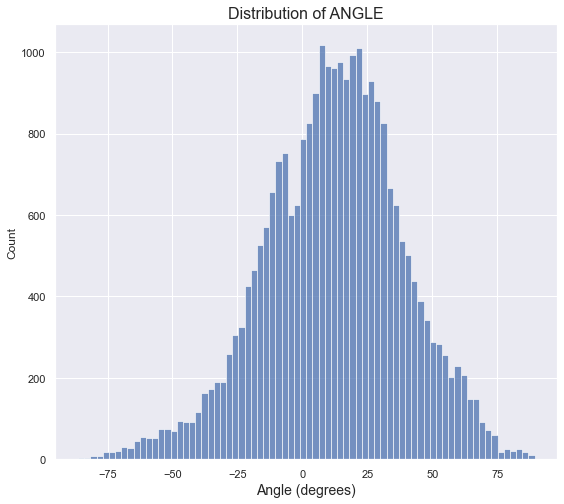

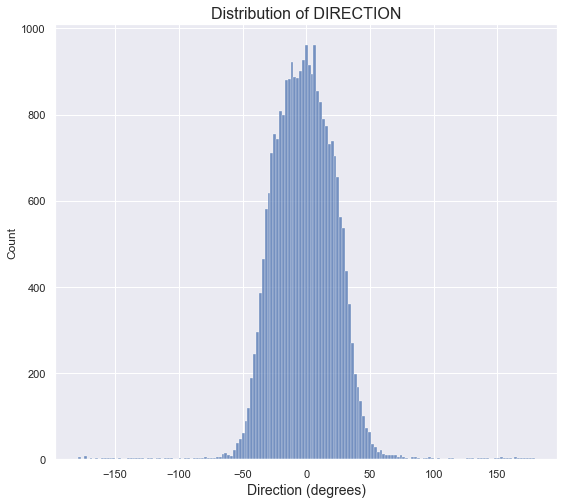

In [3]:
# histogram for EXIT_SPEED
plt.figure(figsize=(9, 8))
sns.histplot(train_data.EXIT_SPEED)
plt.xlabel("Exit Speed (mph)", size=14)
plt.title("Distribution of EXIT_SPEED", size=16)
plt.show()

# histogram for ANGLE
plt.figure(figsize=(9, 8))
sns.histplot(train_data.ANGLE)
plt.xlabel("Angle (degrees)", size=14)
plt.title("Distribution of ANGLE", size=16)
plt.show()

# histogram for DIRECTION
plt.figure(figsize=(9, 8))
sns.histplot(train_data.DIRECTION)
plt.xlabel("Direction (degrees)", size=14)
plt.title("Distribution of DIRECTION", size=16)
plt.show()

We see from the distribution plots that all of the target variables have a strong central tendency and appear to be normally distributed. Since the assumption of normality is valid, let's implement the first two methods.

#### Method 1: The Naive Approach

For this approach, we calculate the mean of each target variable and use that as the predicted value for each observation.

In [4]:
# isolate the target variables
target_vars = train_data.loc[:, ['EXIT_SPEED', 'ANGLE', 'DIRECTION']]

# compute the mean for each target variable, use it
# as the predicted value for each observation, and
# compute the RMSE
np.sqrt(((target_vars - target_vars.mean())**2).mean()).round(4)

EXIT_SPEED    14.4783
ANGLE         26.7707
DIRECTION     25.2220
dtype: float64

Since we haven't tried any other solutions yet, we don't know if this is a good approach or not, although we now have our baseline RMSE for comparison. Those experienced in statistics will note that in this case, the RMSE is the same as the standard deviation of the target variables. The computation below confirms this.

In [5]:
# compute the standard deviation for each target variable
target_vars.std().round(4)

EXIT_SPEED    14.4786
ANGLE         26.7712
DIRECTION     25.2225
dtype: float64

#### Method 2: Simulation with Normally Distributed Numbers

For this approach, we use the mean and standard deviation of each target variable to select a series of normally distributed numbers as the predicted values.

In [6]:
# loop through each target variable and select an array
# of normally distributed numbers, use those numbers as
# the predicted values, and compute the RMSE for each
# target variable
for var in target_vars.columns:
    rmse = mean_squared_error(target_vars[var],
                              ss.norm.rvs(loc=target_vars[var].mean(),
                                          scale=target_vars[var].std(),
                                          size=len(target_vars[var])),
                              squared=False)
    print(var, "RMSE:", round(rmse, 4))

EXIT_SPEED RMSE: 20.4749
ANGLE RMSE: 37.7242
DIRECTION RMSE: 35.876


This method performed markedly worse than method 1. Noting that the target variables have a strong central tendency, if we decrease the standard deviation by several factors we should be able to select numbers that are more closely clustered, perhaps improving the RMSE. We'll try dividing the standard deviation by factors from 1 to 100 to see if that improves the RMSE.

In [7]:
# loop through each target variable, then use a list
# comprehension to compute the RMSE for each array of
# predicted values while the standard deviation is
# is divided by factors from 1 to 100. select the
# the minimum factor that produces the last meaningful
# change in RMSE
for var in target_vars.columns:
    rmse = [mean_squared_error(target_vars[var],
                              ss.norm.rvs(loc=target_vars[var].mean(),
                                          scale=(target_vars[var].std() / x),
                                          size=len(target_vars[var])),
                              squared=False) for x in range(1, 101)]
    min_idx = np.argmin(np.array(rmse).round(2))
    print(var)
    print("     ", "Factor:", min_idx + 1)
    print("     ", "RMSE:", round(rmse[min_idx], 4))

EXIT_SPEED
      Factor: 27
      RMSE: 14.4841
ANGLE
      Factor: 38
      RMSE: 26.7717
DIRECTION
      Factor: 45
      RMSE: 25.22


Reducing the scale of the standard deviation that is used to select the normally distributed numbers definitely improves our results. However, this method doesn't seem to perform any better than method 1 and if you re-run the cell above you'll notice that the factor changes each time due to randomness, meaning that this method isn't stable. Thus far, method 1 is producing the best results. Let's try modeling using several different regressors to see if we can do better.

#### Data Cleaning and Preparation for Modeling

In [8]:
# copy the original train dataset so it is not modified
train_2 = train_data.copy()

# remove duplicate rows
train_2.drop_duplicates(inplace=True, ignore_index=True)

# remove unwanted columns
train_2 = train_2.drop(columns=['BATTER_UID', 'EVENT_RESULT_KEY', 'PITCH_RESULT_KEY',
                                'PA', '1B', '2B', '3B', 'HR'])

# create training and validation sets
# set the random_state to ensure reproducibility
X_train, X_val, y_train, y_val = train_test_split(train_2.iloc[:, :-3], train_2.iloc[:, -3:],
                                                  train_size=0.8, random_state=39)

# create separate lists of feature names to assist with processing
num_attrib = ['AVG', 'OBP', 'SLG', 'RELEASE_SPEED', 'PLATE_X', 'PLATE_Z',
              'INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'VERTICAL_APPROACH_ANGLE',
              'HORIZONTAL_APPROACH_ANGLE']
cat_attrib = ['VENUE_KEY']
remainder = ['OUTS', 'BALLS', 'STRIKES', 'BATS_LEFT', 'THROWS_LEFT', 'PITCH_NUMBER']

# create a column transformer that will standardize the numerical
# columns and create dummy variables for the VENUE_KEY column
# note that one venue key was dropped to avoid the dummy variable trap
transformers = ColumnTransformer([
    ('num', StandardScaler(), num_attrib),
    ('cat', OneHotEncoder(drop=[2683]), cat_attrib)],
     remainder='passthrough')

# fit_transform the features without saving the output
transformers.fit_transform(X_train)

# get the list of categorical feature names from the transformer
enc_cat_features = transformers.named_transformers_['cat'].get_feature_names_out()

# assemble the full list of feature names
labels = np.concatenate([num_attrib, enc_cat_features, remainder])

# transform the training and validation data and reassemble them into dataframes
X_train_trans = pd.DataFrame(transformers.transform(X_train), columns=labels)
X_val_trans = pd.DataFrame(transformers.transform(X_val), columns=labels)

#### Method 3: Single Output Regressors

For method 3, we train and validate three separate regression models against the three individual target variables. A new version of each model is employed on each target variable. The RMSE for each respective model is displayed.

In [9]:
# create a function to assist with model testing
def model_search(X_train, X_val, y_train, y_val):
    """
    This function creates a pipeline that trains and
    validates three separate regression models. It prints
    each respective model's root mean squared error
    to the display.
    
    Args:
        X_train - a m x n dataframe
        X_val   - a m x n dataframe
        y_train - a n x 1 array
        y_val   - a n x 1 array
        
    Returns:
        None
    """
    # instantiate, train, and validate an OLS model
    ols = LinearRegression(n_jobs=n_jobs)
    ols.fit(X_train, y_train.values.ravel())
    y_pred = ols.predict(X_val)
    y_true = y_val.values.ravel()
    print("OLS RMSE: {}".format(mean_squared_error(y_true, y_pred, squared=False).round(4)))
    
    # instantiate, train, and validate a LASSO model
    l_reg = Lasso()
    l_reg.fit(X_train, y_train.values.ravel())
    y_pred = l_reg.predict(X_val)
    y_true = y_val.values.ravel()
    print("Lasso RMSE: {}".format(mean_squared_error(y_true, y_pred, squared=False).round(4)))
    
    # instantiate, train, and validate an SVR model
    svr = SVR()
    svr.fit(X_train, y_train.values.ravel())
    y_pred = svr.predict(X_val)
    y_true = y_val.values.ravel()
    print("SVR RMSE: {}".format(mean_squared_error(y_true, y_pred, squared=False).round(4)))

In [10]:
# for each target column, employ our custom model search function
# on the transformed dataset
for col in y_train.columns:
    print("Target variable:", target_vars.columns[col])
    model_search(X_train_trans, X_val_trans, y_train[[col]], y_val[[col]])
    print()

Target variable: EXIT_SPEED
OLS RMSE: 14.1965
Lasso RMSE: 14.3591
SVR RMSE: 13.2382

Target variable: ANGLE
OLS RMSE: 25.7399
Lasso RMSE: 25.8711
SVR RMSE: 25.3218

Target variable: DIRECTION
OLS RMSE: 23.4149
Lasso RMSE: 23.5403
SVR RMSE: 23.0226



We note that the SVR model slightly outperforms OLS and LASSO regression for each target variable, which may be due to some non-linearity in the dataset. Instead of spending time conducting a grid search to find the optimal hyperparameters for our SVR model, let's try using a regressor that can produce multiple outputs by default.

#### Method 4: Multioutput Regressor

For the last method, we train and validate a Random Forest Regressor (RFR). Since RFR models are capable of predicting multiple outputs, there is no need to instantiate multiple models as was the case with the last method.

In [11]:
# instantiate, train, and validate a RFR model
# using the transformed dataset
rfr = RandomForestRegressor(n_jobs=n_jobs)
rfr.fit(X_train_trans.values, y_train)
y_pred = rfr.predict(X_val_trans.values)
print("RFR RMSE:\n{}".format(np.sqrt(((y_val - y_pred)**2).mean()).round(4)))

RFR RMSE:
0    12.8305
1    25.0868
2    22.8055
dtype: float64


We see that the RFR model slightly outperforms the SVR model. Considering that the RFR model is simpler to employ, we will use the RFR model going forward. But before we employ the RFR model on the test.csv dataset, let's plot the predicted values vs the actual values to visualize where the errors are occurring.

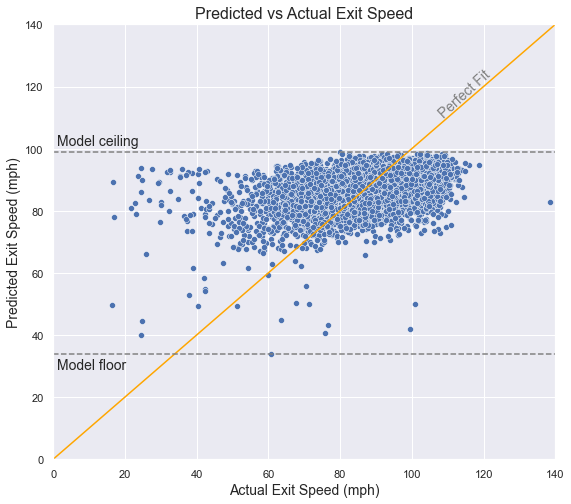

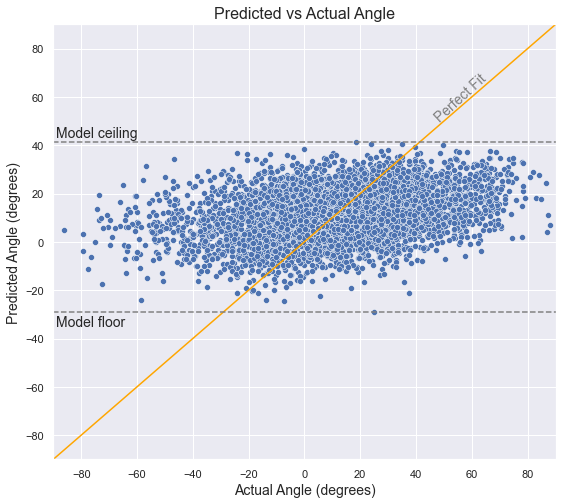

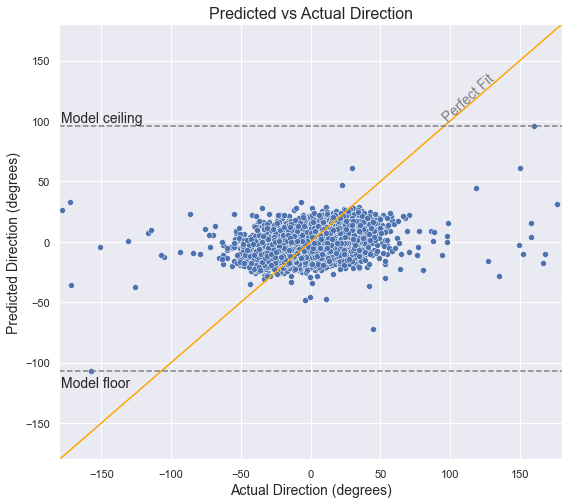

In [12]:
# EXIT_SPEED
plt.figure(figsize=(9, 8))
sns.lineplot(x=[0, 140], y=[0, 140], color='#ffa600')
sns.scatterplot(x=y_val.iloc[:, 0], y=y_pred[:, 0])
plt.hlines(y=max(y_pred[:, 0]), xmin=0, xmax=140, color="grey", linestyles='dashed')
plt.text(1, max(y_pred[:, 0]) + 2, s="Model ceiling", fontsize=14)
plt.hlines(y=min(y_pred[:, 0]), xmin=0, xmax=140, color="grey", linestyles='dashed')
plt.text(1, min(y_pred[:, 0]) - 5, s="Model floor", fontsize=14)
plt.text(107, 110, s="Perfect Fit", fontsize=14, rotation=42.5, color='grey')
plt.xlim(0, 140)
plt.ylim(0, 140)
plt.xlabel("Actual Exit Speed (mph)", size=14)
plt.ylabel("Predicted Exit Speed (mph)", size=14)
plt.title("Predicted vs Actual Exit Speed", size=16)
plt.show()

# ANGLE
plt.figure(figsize=(9, 8))
sns.lineplot(x=[-90, 90], y=[-90, 90], color='#ffa600')
sns.scatterplot(x=y_val.iloc[:, 1], y=y_pred[:, 1])
plt.hlines(y=max(y_pred[:, 1]), xmin=-90, xmax=90, color="grey", linestyles='dashed')
plt.text(-89, max(y_pred[:, 1]) + 2, s="Model ceiling", fontsize=14)
plt.hlines(y=min(y_pred[:, 1]), xmin=-90, xmax=90, color="grey", linestyles='dashed')
plt.text(-89, min(y_pred[:, 1]) - 6, s="Model floor", fontsize=14)
plt.text(46, 50, s="Perfect Fit", fontsize=14, rotation=42.5, color='grey')
plt.xlim(-90, 90)
plt.ylim(-90, 90)
plt.xlabel("Actual Angle (degrees)", size=14)
plt.ylabel("Predicted Angle (degrees)", size=14)
plt.title("Predicted vs Actual Angle", size=16)
plt.show()

# DIRECTION
plt.figure(figsize=(9, 8))
sns.lineplot(x=[-180, 180], y=[-180, 180], color='#ffa600')
sns.scatterplot(x=y_val.iloc[:, 2], y=y_pred[:, 2])
plt.hlines(y=max(y_pred[:, 2]), xmin=-180, xmax=180, color="grey", linestyles='dashed')
plt.text(-179, max(y_pred[:, 2]) + 3, s="Model ceiling", fontsize=14)
plt.hlines(y=min(y_pred[:, 2]), xmin=-180, xmax=180, color="grey", linestyles='dashed')
plt.text(-179, min(y_pred[:, 2]) - 13, s="Model floor", fontsize=14)
plt.text(93, 100, s="Perfect Fit", fontsize=14, rotation=42.5, color='grey')
plt.xlim(-180, 180)
plt.ylim(-180, 180)
plt.xlabel("Actual Direction (degrees)", size=14)
plt.ylabel("Predicted Direction (degrees)", size=14)
plt.title("Predicted vs Actual Direction", size=16)
plt.show()

In all three plots we see that the RFR model is overpredicting smaller values and underpredicted larger values, which is expected. We also see that the model has implemented pretty tight ceilings and floors to account for outliers in the data. Given more time, we could instantiate and test a neural network on the dataset. However, there is no guarantee that it would perform better than the models we tested. That said, the RFR model is our best performing model, so we will employ it on the test.csv dataset.

In [13]:
# copy the original test dataset
test_2 = test_data.copy()

# remove the BATTER_UID column from the test dataset
test_2.drop(columns='BATTER_UID', inplace=True)

# instantiate a new transformer
transformers = ColumnTransformer([
    ('num', StandardScaler(), num_attrib),
    ('cat', OneHotEncoder(drop=[2683]), cat_attrib)],
     remainder='passthrough')

# fit and transform the full training dataset
train_2_full = pd.DataFrame(transformers.fit_transform(train_2.iloc[:, :-3]), columns=labels)

# transform the test dataset
test_2 = pd.DataFrame(transformers.transform(test_2), columns=labels)

# instantiate a new RFR, train it, and employ the
# model on the test.csv dataset
rfr = RandomForestRegressor(n_jobs=n_jobs)
rfr.fit(train_2_full.values, train_2.iloc[:, -3:].values)
test_pred = rfr.predict(test_2.values)

# put the results in a dataframe
pred_df = pd.DataFrame(test_pred, columns=['EXIT_SPEED', 'ANGLE', 'DIRECTION'])

# concatenate the results to the original test dataset
test_modified = pd.concat([test_data, pred_df.round(4)], axis=1)

# export the test_modified dataframe to a .csv
test_modified.to_csv("test_modified_v2.csv", index=False)